In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import beaconsHelper
import trilateration
import CoreLocation

beacon_locations = {
    3: (62, 0),
    2: (173, 0),
    4: (212, 93),
    5: (309, 173),
    8: (309, 303),
    9: (165, 341),
    6: (45, 110),
    1: (18, 224),
    7: (0, 307)
}
# beacon_locations = {1: (171, 0), 2: (0, 108), 3: (0, 216), 4: (0, 0), 5: (279, 101), 6: (108, 251), 7:(121, 144), 8: (279, 179), 9: (273, 0)}
client_locations = {"cattalyya": (160, 109), "ray": (236, 88)}
# ray started at 12:45 am

In [ ]:
beacon_locations_3D = {}
for minor, location in beacon_locations.items():
    x, y = location
    beacon_locations_3D[minor] = np.array([x, y, 0])

In [ ]:
import json

#ray 1525668401385.json
data = []
with open('/root/6S062/indoor-loc/Server/collected_data/cattalyya-13-slow-old/ibeacons/1526267744849.json', 'r') as f:
    data += json.load(f)
with open('/root/6S062/indoor-loc/Server/collected_data/cattalyya-13-slow-old/ibeacons/1526267804847.json', 'r') as f:
    data += json.load(f)

In [ ]:
data_by_id = {}
rssi_data_by_timestamp = beaconsHelper.get_rssi_data_by_timestamp(data, rssi_thres=-65)
print(len(rssi_data_by_timestamp.keys()))

In [ ]:
# rssi_data_by_timestamp

### Average prediction over 1 minute

In [ ]:
for beacon_id in range(1, 10):
    ibeacon = beaconsHelper.get_rssi_data_from_id(beacon_id, rssi_data_by_timestamp)
#     print ibeacon
    ibeacon = beaconsHelper.get_smooth_rssi_data(ibeacon, 5, option="median")
#     print "\n\n\n",ibeacon
    data_by_id[beacon_id] = ibeacon
data_by_timestamp = beaconsHelper.convert_rssi_data_by_id_to_timestamp(data_by_id)
data_by_timestamp = beaconsHelper.convert_to_rough_timestamp(data_by_timestamp)
# print(list(sorted(data_by_timestamp.keys())))
print(data_by_timestamp)

In [ ]:
timestamp = 1525668397.2775578 # ray
# timestamp = 1525666731.260067 # cattalyya
conversion = 39.97 # meters to inches
A = -64
n = 2

subject_name = "cattalyya"
predicted_locations = CoreLocation.Locations(subject=subject_name)
xs, ys = zip(*beacon_locations.values())
margin = 50
axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
# print data_by_timestamp

for timestamp in data_by_timestamp.keys():
    rssi_values = beaconsHelper.get_rssi_values(data_by_timestamp, timestamp)
    beacon_distances = beaconsHelper.get_beacon_distances_from_rssi(rssi_values, A, n, conversion)
    print beacon_distances
    predicted_loc = trilateration.trilaterate_ratios(beacon_locations, beacon_distances)
#     predicted_loc = trilateration.trilaterate(beacon_locations, beacon_distances, L2=True)

    # TODO: check why None result from trilateration
    if predicted_loc is not None:
        predicted_locations.add_np_point(predicted_loc, timestamp)
    
subject_point = CoreLocation.Point2D.numpy_to_point(client_locations[subject_name], None)

fig, ax = plt.subplots(figsize=(6,8))
ax = predicted_locations.visualize(actual_loc=subject_point, ax_limits=axis_limits, fig_ax=(fig, ax))
ax.axis('equal')
plt.gca().invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(6,8))
ax = predicted_locations.plot(actual_loc=subject_point, ax_limits=axis_limits, fig_ax=(fig, ax))
ax.axis('equal')
plt.gca().invert_yaxis()
plt.show()



In [ ]:
predicted_locations.points

In [ ]:
# # NO Smooth
# data_by_timestamp = ibeaconsHelper.get_rssi_data_by_timestamp(data) # old data format use get_data_by_timestamp

# timestamp = 1525668397.2775578 # ray
# # timestamp = 1525666731.260067 # cattalyya
# conversion = 39.97 # meters to inches
# A = -64
# n = 2

# subject_name = "cattalyya"
# predicted_locations = CoreLocation.Locations(subject=subject_name)
# xs, ys = zip(*beacon_locations.values())
# margin = 50
# axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
# # print data_by_timestamp

# for timestamp in data_by_timestamp.keys():
#     rssi_values = ibeaconsHelper.get_rssi_values(data_by_timestamp, timestamp)
#     beacon_distances = ibeaconsHelper.get_beacon_distances_from_rssi(rssi_values, A, n, conversion)
#     predicted_loc = trilateration.trilaterate(beacon_locations, beacon_distances, L2=True)
#     # TODO: check why None result from trilateration
#     if predicted_loc is not None:
#         predicted_locations.add_np_point(predicted_loc, timestamp)
    
# subject_point = CoreLocation.Point2D.numpy_to_point(client_locations[subject_name], None)
# predicted_locations.visualize(subject_point, ax_limits=axis_limits)
# predicted_locations.plot(subject_point, ax_limits=axis_limits)

# # Hyperbolic multilateration 


Should we filter out data if rssi are too low? It's no longer reliable after it's below some threshold.

# Results

In [ ]:
def plot_prediction(beacon_locations, beacon_distances, predicted_location, client_names):
    margin = 50
    xs, ys = zip(*beacon_locations.values())
    axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
    fig, ax = plt.subplots()
    
    # assume all beacons in beacon_distances are also in beacon_locations
    for minor in beacon_distances:
        x, y = beacon_locations[minor][:2]
        distance = beacon_distances[minor]
        circle = plt.Circle((x, y), distance, fill=False)
        ax.add_artist(circle)
        ax.plot(x, y, 'bo')
        ax.annotate(minor, (x, y), xytext=(x + 5, y + 5))

    for client_name in client_names:
        x, y = client_locations[client_name]
        ax.plot(x, y, 'go')
        ax.annotate(client_name, (x, y), xytext=(x + 5, y + 5))

    # prediction
    predicted_x, predicted_y = predicted_location[:2]
    ax.plot(predicted_x, predicted_y, 'ro')
    ax.annotate("prediction", (predicted_x, predicted_y), xytext=(predicted_x + 5, predicted_y + 5))
    plt.axis(axis_limits)
    ax.axis('equal')
    plt.title("A: %.2f, n: %.2f" % (A, n))
    plt.show()

In [ ]:
plot_prediction(beacon_locations, beacon_distances, predicted_locations.points[10].coord, ["ray"])

In [ ]:
print rssi_values

[1.00000011e+00 8.08083615e-07]


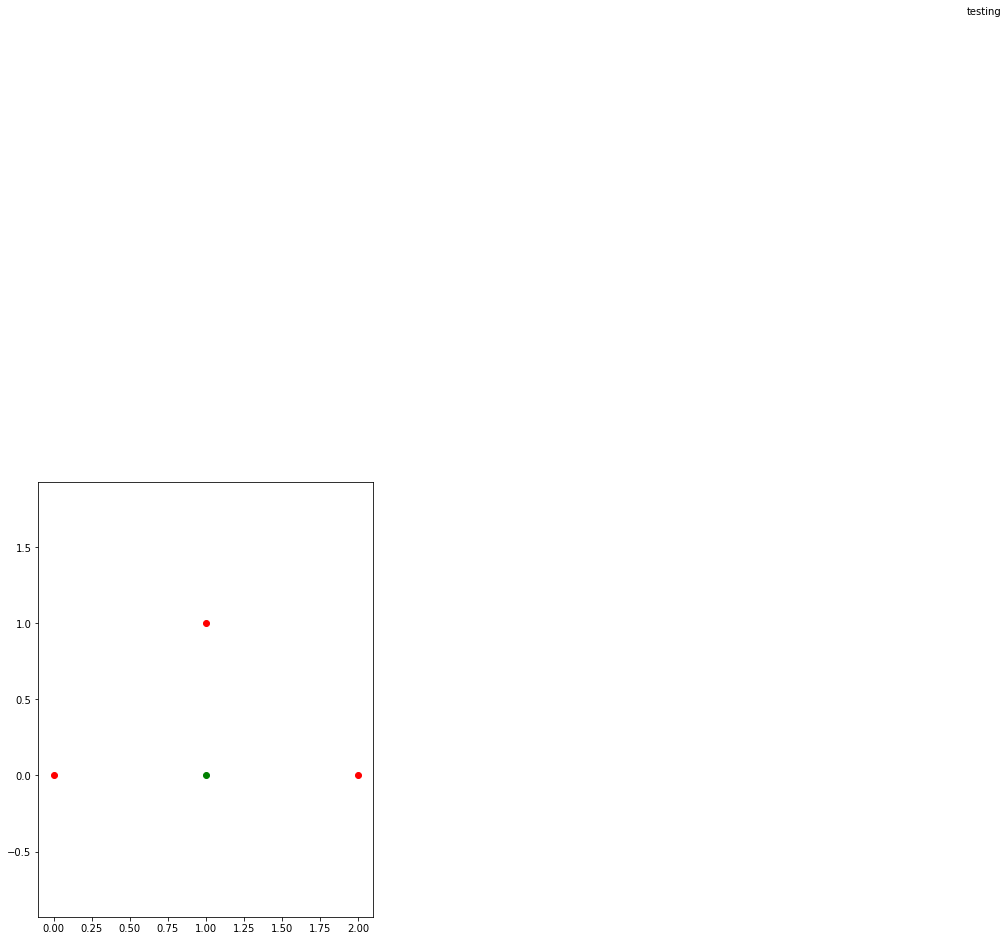

In [3]:
import CoreLocation
import trilateration
import numpy as np
import matplotlib.pyplot as plt

beacon_locations_dict = {1: (2, 0), 2: (0,0), 3:(1, 1)}
beacon_location = CoreLocation.Locations(subject="testing")
for i in beacon_locations_dict.values():
    beacon_location.add_np_point(i)
xs, ys = zip(*beacon_locations_dict.values())
margin=0
axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]

beacon_distances = {1: 1, 2: 1, 3: 1}
res = trilateration.trilaterate(beacon_locations_dict, beacon_distances)
print res

fig, ax = plt.subplots(figsize=(6,8))
ax = beacon_location.plot(actual_loc=CoreLocation.Point2D(res[0], res[1]), ax_limits=axis_limits, fig_ax=(fig, ax))
ax.axis('equal')
plt.show()